In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
import os
import math


In [5]:
def quantimage(image,k):
    i = np.float32(image).reshape(-1,3)
    condition = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,20,1.0)
    ret,label,center = cv2.kmeans(i, k , None, condition,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    final_img = center[label.flatten()]
    final_img = final_img.reshape(image.shape)
    return final_img

#Show img
def plot_img(img,size=(8,8)):
    plt.figure(figsize=size)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# img_path_1="./image/EpiscopalGaudi/3743214471_1b5bbfda98_o.jpg"
# img_path_2="./image/EpiscopalGaudi/4386465943_8cf9776378_o.jpg"
# img_path_3="./image/MountRushmore/9021235130_7c2acd9554_o.jpg"
# img_path_4="./image/EpiscopalGaudi/rotate_20.jpg"

img_path_1="./image/all_image/hand1.jpg"
img_path_2="./image/all_image/hand2.jpg"
img_path_3="./image/all_image/hand3.jpg"
img_path_4="./image/all_image/hand_fake.jpg"
img_path_5="./image/EpiscopalGaudi/4386465943_8cf9776378_o.jpg"
img_path_6="./image/MountRushmore/9021235130_7c2acd9554_o.jpg"

img1=cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB) 
img2=cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB) 
img3=cv2.cvtColor(cv2.imread(img_path_3), cv2.COLOR_BGR2RGB) 
img4=cv2.cvtColor(cv2.imread(img_path_4), cv2.COLOR_BGR2RGB) 
img5=cv2.cvtColor(cv2.imread(img_path_5), cv2.COLOR_BGR2RGB) 
img6=cv2.cvtColor(cv2.imread(img_path_6), cv2.COLOR_BGR2RGB) 

In [39]:
image_folder="./image/all_image/"
for filename in os.listdir(image_folder):
    image_path=os.path.join(image_folder,filename)
    img=cv2.imread(image_path)
    img=quantimage(img,8)
    cv2.imwrite(f"./image/all_quantimage/{filename}",img)
# img=cv2.imread(img_path_1)
# img_rotate=rotate_image(img,20)
# plot_img(img_rotate)
# cv2.imwrite("./image/EpiscopalGaudi/rotate_20.jpg",img_rotate)

In [14]:

# img1=img1
# img1=quantimage(img1,8)
# img1_luv=cv2.cvtColor(np.array(img1).astype('float32')/255, cv2.COLOR_RGB2Luv)
# img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
# plot_img(img1,(8,8))
# plot_img(img2,(8,8))

#### CECH

In [6]:
def get_CECH(image,TH_G=30,d=4):
    img1=quantimage(image,8)
    #Xám hóa
    img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    
    h,w,c=img1.shape

    img1_luv=cv2.cvtColor(np.array(img1).astype('float32')/255, cv2.COLOR_RGB2Luv)

    pixels = [(*pixel,) for pixel in img1_luv.reshape(-1, 3)]
    color_list=Counter(pixels)
    # img1_pad=np.pad(img1, ((1,1), (1,1),(0,0)), constant_values=0)
    img1_gray=cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    #Sobel
    sobelx = cv2.Sobel(img1_gray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(img1_gray,cv2.CV_64F,0,1,ksize=3)
        
    e=np.zeros((h,w))
    gradient_f=np.zeros((h,w))
    theta=np.zeros((h,w))
    list_value=[]

    px_1=np.zeros((h,w))
    px_2=np.zeros((h,w))
    py_1=np.zeros((h,w))
    py_2=np.zeros((h,w))

    cout_neg=0
    for i in range(h):
        for j in range(w):
            gradient_f[i][j]=math.sqrt(sobelx[i,j]**2+sobely[i,j]**2)
            theta[i][j]=math.atan(sobely[i,j]/(sobelx[i,j]+0.1))

            if gradient_f[i][j]>TH_G:
                e[i][j]=1
                x1= i - d* math.cos(theta[i][j])
                y1= j + d*math.sin(theta[i][j])
                
                px_1[i][j]=int(x1)
                py_1[i][j]=int(y1)
                x2= i + d* math.cos(theta[i][j])
                y2= j - d*math.sin(theta[i][j])
                px_2[i][j]=int(x2)
                py_2[i][j]=int(y2)
                if x1 <0 or y1 <0 or int(x1) >=h or int(y1) >=w:
                    px_1[i][j]=int(i)
                    py_1[i][j]=int(j)
                    cout_neg+=1
                    
                if x2 <0 or y2 <0 or int(x2) >=h or int(y2) >=w:
                    px_2[i][j]=int(i)
                    py_2[i][j]=int(j)
                    cout_neg+=1
            else:
                e[i][j]=0
    # plot_img(e)
    CECH={}

    for key1 in color_list.keys():
        for key2 in color_list.keys():
            CECH[key1,key2]=0

        
    for i in range(h):
        for j in range(w):
            if e[i][j]==1:
                color_1=img1_luv[int(px_1[i][j])][int(py_1[i][j])]
                color_2=img1_luv[int(px_2[i][j])][int(py_2[i][j])]

                CECH[(color_1[0],color_1[1],color_1[2]),(color_2[0],color_2[1],color_2[2])]+=1
    
    return CECH
    x= [key for key in CECH.keys()]
    y= [CECH[t] for t in x]
    x= [str(key) for key in CECH.keys()]

def color_distance(x1,x2):
    distance=math.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2+(x1[2]-x2[2])**2)
    return distance
    

def compare_CECH(CECH1,CECH2,TH=15):
    keys1=[key for key in CECH1.keys()]
    keys2=[key for key in CECH2.keys()]
    CECH1_sum=sum(CECH1.values())
    CECH2_sum=sum(CECH2.values())
    BW=2.64*TH
    sigma=TH*0.8
    mu=0
    its_list=[]
    # dC_list=[]
    for key1 in keys1:
        for key2 in keys2:
            # print(key1)
            ci=key1[0]
            cj=key1[1]

            ck=key2[0]
            cl=key2[1]

            d1=color_distance(ci,ck)
            d2=color_distance(cj,cl)
            dC = max(d1,d2)
            if dC <= BW:
                its= min(CECH1[key1]/CECH1_sum,CECH2[key2]/CECH2_sum)
                new_its=its*math.exp(-(dC**2)/(2*sigma**2))
                its_list.append(new_its)
                # break
            
    return sum(its_list) #/(len(CECH1)+len(CECH2))

# CECH1=get_CECH(img1)
# CECH2=get_CECH(img2)
# CECH3=get_CECH(img3)
# CECH4=get_CECH(img4)


In [44]:
# image_folder="./image/all_image/"

# data_all={}
# # file_list=[]
# for filename in os.listdir(image_folder):
#     # file_list.append(filename)
#     print(f"Processing: {filename}")
#     image_path=os.path.join(image_folder,filename)

#     img=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
#     CECH=get_CECH(img)

#     data_all[filename]=CECH

# target_file="hand2.jpg"
# result_all={}
# for filename in os.listdir(image_folder):
#     result_all[filename]=compare_CECH(data_all[target_file],data_all[filename],TH=20)

#### HI

In [7]:
def get_HI(image):
    # image=quantimage(image,8)
    plot_img(image,(8,8))
    # h,w,c=img.shape
    pixels = [(*pixel,) for pixel in image.reshape(-1, 3)]
    color_count=Counter(pixels)
    sum_value=sum(color_count.values())
    
    color_list=[(r,g,b) for r in range(0,256) for g in range(0,256) for b in range(0,256)]
    HI={}
    for color in color_list:
        HI[color]=0
    for key in color_count.keys():
        HI[key]=color_count[key]/sum_value
    return HI

def compare_HI(HI1,HI2):
    HI_score=0
    for key in HI1:
        HI_score+=min(HI1[key],HI2[key])

    return HI_score


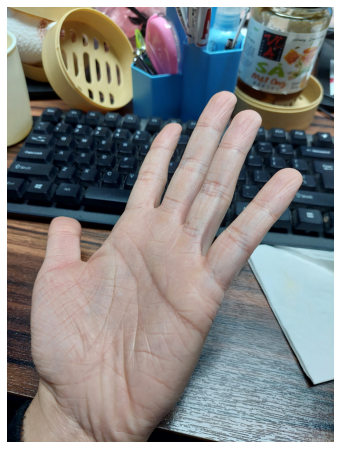

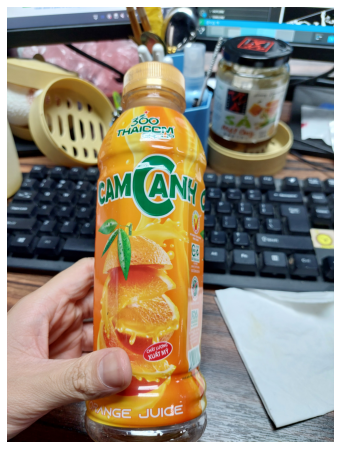

In [14]:
HI1=get_HI(img1)
HI2=get_HI(img4)



In [15]:
compare_HI(HI1,HI2)

0.31419293750477995

#### GWHI

In [8]:
def get_GWHI(image):
    image=quantimage(image,8)
    h,w,c=image.shape

    img1_luv=cv2.cvtColor(np.array(image).astype('float32')/255, cv2.COLOR_RGB2Luv)
    pixels = [(*pixel,) for pixel in img1_luv.reshape(-1, 3)]
    GWHI=Counter(pixels)

    sum_value=sum(GWHI.values())
    for key in GWHI.keys():
        GWHI[key]=GWHI[key]/sum_value
    return GWHI

def compare_GWHI(GWHI1,GWHI2,TH=15):
    BW=TH*2.64
    sigma=TH*0.8
    GWHI_score=0
    w_dict={}
    # check_list_1=[]
    # check_list_2=[]
    for key1 in GWHI1:
        for key2 in GWHI2:
            distance=color_distance(key1,key2)
            if distance > BW:
                w=0
            else:
                w=math.exp(-distance**2/(2*sigma**2))
            score=w*min(GWHI1[key1],GWHI2[key2])
            w_dict[key1,key2]=score

    w_dict={k: v for k, v in sorted(w_dict.items(), key=lambda item: item[1],reverse=True)}
    w_dict
    w_new={}
    check_list_1=[]
    check_list_2=[]

    for key in w_dict:
        if key[0] in check_list_1 or key[1] in check_list_2:
            continue
        # w_new[key]=w_dict[key]
        GWHI_score+=w_dict[key]
        check_list_1.append(key[0])
        check_list_2.append(key[1])
    # for key in w_new:
    #     GWHI_score+=w_new[key]*min(GWHI1[key[0]],GWHI2[key[1]])
        # GWHI_score+=GWHI_score_tmp
    return GWHI_score


In [9]:
GWHI1=get_GWHI(img1)
GWHI2=get_GWHI(img2)
GWHI3=get_GWHI(img3)
GWHI4=get_GWHI(img4)
GWHI5=get_GWHI(img5)
GWHI6=get_GWHI(img6)

In [ ]:
compare_GWHI(GWHI2,GWHI1,TH=15)

NameError: name 'compare_GWHI' is not defined

In [9]:
px_1=np.zeros((h,w))
px_2=np.zeros((h,w))
py_1=np.zeros((h,w))
py_2=np.zeros((h,w))
d=15
for i in range(len(e)):
    for j in range(len(e[0])):
        
        x1= i - d* math.cos(theta[i][j])
        y1= j + d*math.sin(theta[i][j])
        px_1[i][j]=x1
        py_1[i][j]=y1
        x2= i + d* math.cos(theta[i][j])
        y2= j - d*math.sin(theta[i][j])
        px_2[i][j]=x2
        py_2[i][j]=y2

    #     break
    # break


In [96]:
def get_gradient(image,x,y):
  h,w=image.shape
  A_x_y=image[x-1:x+2,y-1:y+2]
  H_x=[[1, 0,-1],[2, 0,-2],[1, 0,-1]]
  H_y=[[1, 2, 1],[0, 0, 0],[-1,-2,-1]]
  print(H_x*A_x_y)

  return


get_gradient(img1_gray,1,1)

[[   0    0    0]
 [   0    0 -380]
 [   0    0 -190]]


In [64]:
img1[0:2,0:2]

array([[[172, 194, 221],
        [172, 194, 221]],

       [[172, 194, 221],
        [172, 194, 221]]], dtype=uint8)

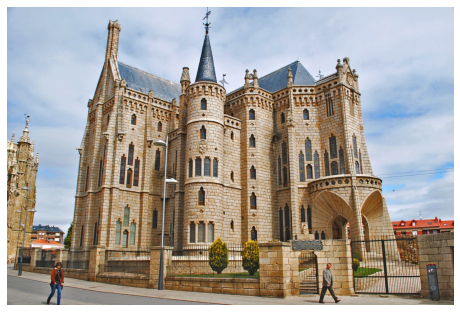

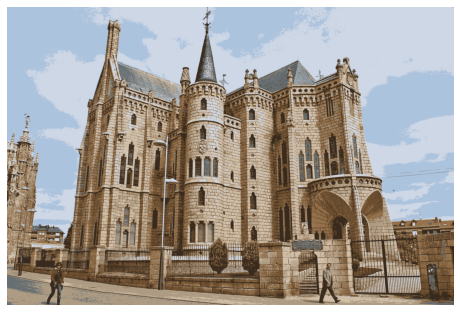

In [16]:

plot_img(img1)
plot_img(new_image)